# Introduction

In this tutorial, we will extend some of the TD algorithms we implemented in the previous tutorial.

# Notebook setup

## Instructions

- Import numpy, scipy and matplotlib
- Configure inline plots
- Import helper modules

In [1]:
% matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from pylab import *

# Import definitions of the environments.
import RL_worlds as worlds

# Import helper functions for plotting.
from plot_util import *

In [2]:
def init_state(params):
    """
    Initialize the state at the beginning of an episode.
    Args:
        params: a dictionary containing the default parameters.
    Returns:
        an integer corresponding to the initial state.
    """
    if params['environment'].name == 'windy_cliff_grid':
        return 0
    elif params['environment'].name == 'n_armed_bandit':
        return 0
    elif params['environment'].name == 'cheese_world':
        return 0
    elif params['environment'].name == 'cliff_world':
        return 0
    elif params['environment'].name == 'quentins_world':
        return 54

def update_state(state, action, params):
    """
    State transition based on world, action and current state.
    Args:
        state: integer corresponding to the current state.
        action: integer corresponding to the action taken.
        params: a dictionary containing the default parameters.
    Returns:
        an integer corresponding to the next state;
        an integer corresponding to the reward received.
    """
    next_state, reward = params['environment'].get_outcome(state, action)
    return next_state, reward
    
def call_policy(state, value, params):
    """
    Call a policy to choose actions, given current state and value function.
    Args:
        state: integer corresponding to the current state.
        value: a matrix indexed by state and action.
        params: a dictionary containing the default parameters.
    Returns:
        an integer corresponding action chosen according to the policy.
    """
    # multiple options for policy
    if params['policy'] == 'epsilon_greedy':
        return epsilon_greedy(state, value, params)
    elif params['policy'] == 'softmax':
        return softmax(state, value, params)
    else: # random policy (if policy not recognized, choose randomly)
        return randint(params['environment'].n_actions)

def update_value(prev_state, action, reward, state, value, params):
    """
    Update the value function.
    Args:
        prev_state: an integer corresponding to the previous state.
        action: an integer correspoding to action taken.
        reward: a float corresponding to the reward received.
        state: an integer corresponding to the current state;
          should be None if the episode ended.
        value: a matrix indexed by state and action.
        params: a dictionary containing the default parameters. 
    Returns:
        the updated value function (matrix indexed by state and action).
    """
    if params['learning_rule'] == 'q_learning':
        # off policy learning
        return q_learning(prev_state, action, reward, state, value, params)
    elif params['learning_rule'] == 'sarsa':
        # on policy learning
        return sarsa(prev_state, action, reward, state, value, params)
    else:
        print('Learning rule not recognized')

def default_params(environment):
    """
    Define the default parameters.
    Args:
        environment: an object corresponding to the environment.
    Returns:
        a dictionary containing the default parameters, where the keys
            are strings (parameter names).
    """
    params = dict()
    params['environment'] = environment
    
    params['alpha'] = 0.1  # learning rate    
    params['beta'] = 10  # inverse temperature    
    params['policy'] = 'epsilon_greedy'
    params['epsilon'] = 0.05  # epsilon-greedy policy
    params['learning_rule'] = 'q_learning'
    params['epsilon_decay'] = 0.9
    
    if environment.name == 'windy_cliff_grid':
        params['gamma'] = 0.6  # temporal discount factor
    elif environment.name == 'n_armed_bandit':
        params['gamma'] = 0.9  # temporal discount factor
    elif environment.name == 'cliff_world':
        params['gamma'] = 1.0  # no discounting
    elif environment.name == 'cheese_world':
        params['gamma'] = 0.5  # temporal discount factor
    elif environment.name == 'quentins_world':
        params['gamma'] = 0.9  # temporal discount factor

    return params

In [3]:
def run_rl(params, n_episodes = 500, n_steps = 1000):
    env = params["environment"]
    value = np.zeros((env.n_states, env.n_actions))
    rewards = []
    for episode in range(n_episodes):
        state = init_state(params)
        reward_sum = 0
        for step in range(n_steps):
            action = call_policy(state, value, params)
            next_state, reward = update_state(state, action, params)
            reward_sum += reward
            value = update_value(state, action, reward, next_state, value, params)  
            state = next_state
            if next_state == None: break
        rewards.append(reward_sum)
    return value, rewards

In [4]:
def plot_rl(params, value, rewards):
    plot_state_action_values(params["environment"], value)
    plot_quiver_max_action(params["environment"], value)
    plot_heatmap_max_val(params["environment"], value)
    plot_rewards(len(rewards), rewards)
    plt.show()

In [5]:
def q_learning(state, action, reward, next_state, value, params):
    max_value = max(value[next_state,:]) if next_state is not None else 0
    delta = reward + params["gamma"] * max_value - value[state, action]
    value[state, action] += params["alpha"] * delta
    return value

def sarsa(state, action, reward, next_state, value, params):
    next_action =  call_policy(next_state, value, params)
    next_value = value[next_state, next_action] if next_state != None else 0
    delta = reward + params["gamma"] * next_value - value[state, action]
    value[state, action] += params["alpha"] * delta
    return value

In [6]:
def epsilon_greedy(state, value, params):
    if np.random.rand() < 1 - params["epsilon"]: 
        a = argmax(value[state, :])
    else:
        a = np.random.randint(params["environment"].n_actions)
    params["epsilon"] *= params['epsilon_decay'] 
    return a

# Exercise 1: $\epsilon$ decay

1. Modify the code you wrote for the $\epsilon$-greedy policy so that the $\epsilon$ (proportion of random choices) decreases over time.
2. Test the new policy with different learning algorithms. How does the decay affect your results?

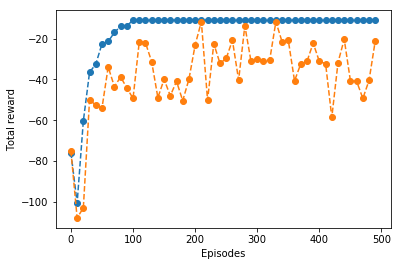

In [260]:
for decay in np.linspace(0, 1, 2):
    params = default_params(worlds.cliff_world())
    params["epsilon"] = 0.1
    params["alpha"] = 0.3
    params["policy"] = "epsilon_greedy"
    params["learning_rule"] = "q_learning"
    params["epsilon_decay"] =  decay
    value, rewards = run_rl(params)
    plot_rewards(len(rewards), rewards)

# Exercise 2: Sarsa($\lambda$)

1. You can improve the performance of TD algorithms by allowing faster back propagation. Modify your Sarsa algorithm from the previous tutorial to obtain Sarsa($\lambda$), which makes use of eligibility traces to propagate the strengthening effect of each reward into the whole sequence of actions that led to it.
2. To explore the effect of eligibility traces on learning, run Sarsa($\lambda$) on Quentin's world, testing different combinations of $\lambda$ and $\alpha$ values. How does $\lambda$ affect the efficiency of Sarsa?

In [7]:
def run_sarsa_lambda(params, n_episodes = 500, n_steps = 1000):
    env = params["environment"]
    value = np.zeros((env.n_states, env.n_actions))
    rewards = []
    for episode in range(n_episodes):
        trace = np.zeros_like(value)
        state = init_state(params)
        reward_sum = 0
        for step in range(n_steps):
            action = call_policy(state, value, params)
            next_state, reward = update_state(state, action, params)
            reward_sum += reward
            value, trace = sarsa_lambda(state, action, reward, next_state, value, trace, params)  
            state = next_state
            if next_state == None: break
        rewards.append(reward_sum)
    return value, rewards

In [8]:
def sarsa_lambda(state, action, reward, next_state, value, trace, params):
    next_action =  call_policy(next_state, value, params)
    next_value = value[next_state, next_action] if next_state != None else 0
    delta = reward + params["gamma"] * next_value - value[state, action]
    trace *= params["gamma"] * params["lambda"]
    trace[state, action] += 1
    value += trace * params["alpha"] * delta
    return value, trace

In [25]:
def mean_reward(a, l, plot = False):
    params = default_params(worlds.quentins_world())
    params["policy"] = "epsilon_greedy"
    params["epsilon_decay"] =  0.999
    params["alpha"] = a
    params["lambda"] = l
    value, rewards = run_sarsa_lambda(params, n_episodes = 10)
    if plot: 
        plt.plot(rewards)
        plt.xlabel("episode")
        plt.ylabel("reward")
#     time = argmax(np.array(rewards) >= -0.01)
    return np.mean(rewards)

-0.29999999999999999

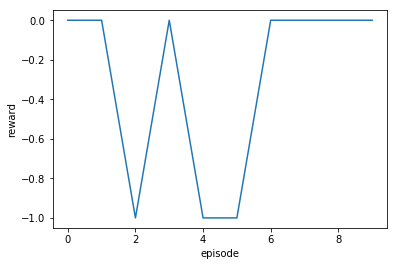

In [29]:
mean_reward(0.001, 0, plot = True)

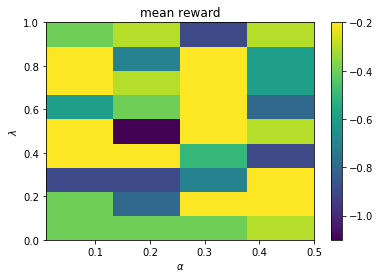

In [27]:
x = np.linspace(0.01, 0.5, 5) # alpha
y = np.linspace(0, 1, 10) # lambda

reward = np.array([[mean_reward(a, l) for a in x] for l in y ])
plt.pcolor(x, y, reward)
plt.xlabel("$\\alpha$")
plt.ylabel("$\\lambda$")
plt.title("mean reward")
plt.colorbar()

In [102]:
def epsilon_greedy(state, value, params):
    #print 1
    #print state
    value_now = value[state,:]
    if rand() > params['epsilon']:
        action = where(value_now == max(value_now))[0][0]
    else:
        # We deal with ties by selecting randomly.
        action = randint(len(value_now)) 
    return action

def q_learning(prev_state, action, reward, state, value, params):
    # maximum value at current state
    if state == None:
        max_value = 0
    else:
        max_value = max(value[state,:])
    # value of previous state-action pair
    prev_value = value[prev_state, action]
    # reward prediction error
    delta = reward + params['gamma'] * max_value - prev_value  # gamma is the temporal discount factor
    # update value of previous state-action pair
    value[prev_state, action] = prev_value + params['alpha'] * delta  # alpha: learning rate
    
    return value
def run_learning(value, params, n_episodes, max_steps):
    reward_sums = np.zeros(n_episodes)
    # Loop over episodes
    for episode in xrange(n_episodes):
        #params['epsilon']=params['epsilon']*params['gamma']
        state = init_state(params)  # initialize state    
        step = 0
        reward_sum = 0
        # Make sure to break after max number of steps
        while step < max_steps:
            action = call_policy(state, value, params)  # get action from policy
            next_state, reward = update_state(state, action, params)  # update state based on action
            value = update_value(state, action, reward, next_state, value, params)  # update value function
            state = next_state
            reward_sum += reward  # sum rewards obtained
            step += 1
            if next_state == None:
                break  # episode ends

        reward_sums[episode] = reward_sum

    return reward_sums, value
def modified_run_learning(value, params, n_episodes, max_steps):
    reward_sums = np.zeros(n_episodes)
    # Loop over episodes
    for episode in xrange(n_episodes):
        params['epsilon']=params['epsilon']*params['gamma']
        state = init_state(params)  # initialize state    
        step = 0
        reward_sum = 0
        # Make sure to break after max number of steps
        while step < max_steps:
            action = call_policy(state, value, params)  # get action from policy
            next_state, reward = update_state(state, action, params)  # update state based on action
            value = update_value(state, action, reward, next_state, value, params)  # update value function
            state = next_state
            reward_sum += reward  # sum rewards obtained
            step += 1
            if next_state == None:
                break  # episode ends

        reward_sums[episode] = reward_sum

    return reward_sums, value

In [34]:
def sarsa(prev_state, action, reward, state, value, params):
    # select the expected value at current state based on our
    # policy by sampling from it
    if state == None:
        policy_value = 0
    else:
        # sample action from the policy for the next state
        policy_action = call_policy(state, value, params)
        # get the value based on the action sampled from the policy
        policy_value = value[state, policy_action]
    
    # value of previous state-action pair
    prev_value = value[prev_state, action]
    # reward prediction error
    delta = reward + params['gamma'] * policy_value - prev_value  # gamma is the temporal discount factor
    
    # update value of previous state-action pair
    value[prev_state, action] = prev_value + params['alpha'] * delta  # alpha: learning rate
    
    return value
def modified_sarsa(prev_state, action, reward, state, value, params):
    # select the expected value at current state based on our
    # policy by sampling from it
    if state == None:
        policy_value = 0
    else:
        # sample action from the policy for the next state
        policy_action = call_policy(state, value, params)
        # get the value based on the action sampled from the policy
        policy_value = value[state, policy_action]
    
    # value of previous state-action pair
    prev_value = value[prev_state, action]
    #trace = params['lamda']*params['gamma']*trace trace[state]+=1
    
    Trace=params['Trace']
    Trace[prev_state,action]+=1
    #Trace=Trace*params['lamda']*params['gamma'] 
    # reward prediction error
    delta = reward + params['gamma'] * policy_value - prev_value  # gamma is the temporal discount factor
    # update value of previous state-action pair
    env = params['environment']
    #for s in range(0,env.n_states):
    #    for a in range(0,env.n_actions):
    #        value[s, a] = prev_value + params['alpha'] * (Trace[s,a]* delta)
    
    #delta = reward + params['gamma'] * policy_value - prev_value  # gamma is the temporal discount factor
    #value[prev_state, action] = prev_value + params['alpha'] * delta  # alpha: learning rate
    value += params['alpha']*delta*Trace
    Trace = Trace * params['gamma']*params['lamda']
    
    params['Trace']=Trace
    
    return value

In [73]:
def get_reward(a, l):
    env = worlds.quentins_world()
    params = default_params(environment=env)
    params['learning_rule'] = 'sarsa'
    params['policy'] = 'epsilon_greedy'
    params['epsilon'] = 0.02
    params['beta'] = 10
    params['gamma'] = 0.8
    params['alpha'] = a #0.1
    params["lamda"] = l
    n_episodes = 1000
    max_steps = 300
    value = np.ones((env.n_states, env.n_actions))
    reward_sums, value = run_learning(value, params, n_episodes, max_steps)
    return reward_sums

0.503


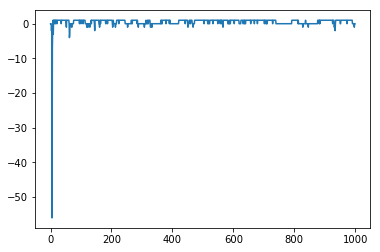

In [142]:
r = get_reward(0.9, 0)
print mean(r)
plt.plot(r)

In [146]:
x = np.linspace(0.01, 1, 5) # alpha
y = np.linspace(0, 1, 10) # lambda

# reward = np.array([[mean(get_reward(a, l)[:100]) for a in x] for l in y ])
first_max_time = np.array([[argmax(np.array(get_reward(a, l)) > 0.5) for a in x] for l in y ])

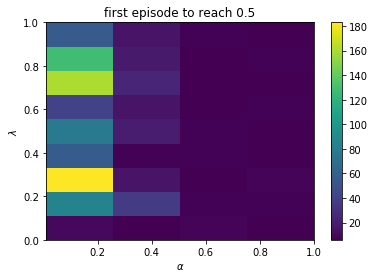

In [148]:
plt.pcolor(x, y, np.flipud(first_max_time))
plt.xlabel("$\\alpha$")
plt.ylabel("$\\lambda$")
plt.title("first episode to reach 0.5")
plt.colorbar()

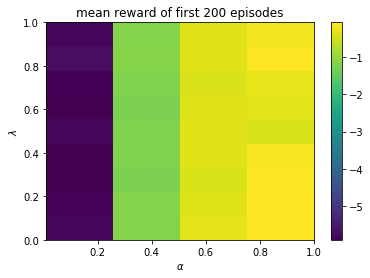

In [144]:
plt.pcolor(x, y, np.flipud(reward))
plt.xlabel("$\\alpha$")
plt.ylabel("$\\lambda$")
plt.title("mean reward of first 200 episodes")
plt.colorbar()